In [1]:
import pandas as pd
import zipfile
from datetime import datetime

### Load Data

In [2]:
#load zip file
# i used colab
zf = zipfile.ZipFile(path)

Mounted at /content/drive


In [3]:
#load train data
df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
df_wafers.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,8PFrAN,0,27,True,False
1,8PFrAN,0,28,True,False
2,8PFrAN,0,29,True,False
3,8PFrAN,0,30,True,False
4,8PFrAN,0,31,True,False


In [4]:
#load test data
df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
df_wafers_test.head()

,WaferName,DieX,DieY,IsGoodDie
0,mZa9ls,0,23,True
1,mZa9ls,0,24,True
2,mZa9ls,0,25,True
3,mZa9ls,0,26,True
4,mZa9ls,0,27,True


In [5]:
def plot_wafer_maps(wafer_df_list, figsize, labels = True):
    """
    plot wafer maps for list of df of wafers

    :param wafer_df_list: list, The list of df's of the wafers
    :param figsize: int, the size of the figsize height
    :param labels: bool, Whether to show the layer of labels (based on column 'IsScratchDie')

    :return: None
    """
    def plot_wafer_map(wafer_df, ax, map_type):
        wafer_size = len(wafer_df)
        s = 2**17/(wafer_size)
        if map_type == 'Label':
            mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum()>0 else 'Non-Scratch Wafer'
        else:
            mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum()/(wafer_df['IsGoodDie']).count(), 2))

        ax.set_title(f'{map_type} | Wafer Name: {wafer_df["WaferName"].iloc[0]}, \nSum: {len(wafer_df)} dies. {mes}', fontsize=20)
        ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color = 'green', marker='s', s = s)

        bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
        ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color = 'red', marker='s', s = s)

        if map_type == 'Label':
            scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
            ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color = 'blue', marker='s', s = s)

            ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
            ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color = 'yellow', marker='s', s = s)

            ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
        else:
            ax.legend(['Good Die', 'Bad Die'], fontsize=8)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    import numpy as np
    import matplotlib.pyplot as plt

    if labels:
        fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize*2))
        for idx1, wafer_df in enumerate(wafer_df_list):
            for idx2, map_type in enumerate(['Input', 'Label']):
                plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
    else:
        fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize))
        for idx, wafer_df in enumerate(wafer_df_list):
            plot_wafer_map(wafer_df, ax[idx], 'Input')

    plt.show()

Select the amount of samples you want to display:

wafer data and labelels
the wafer and below the same wafer with the labeld scratch ploted above

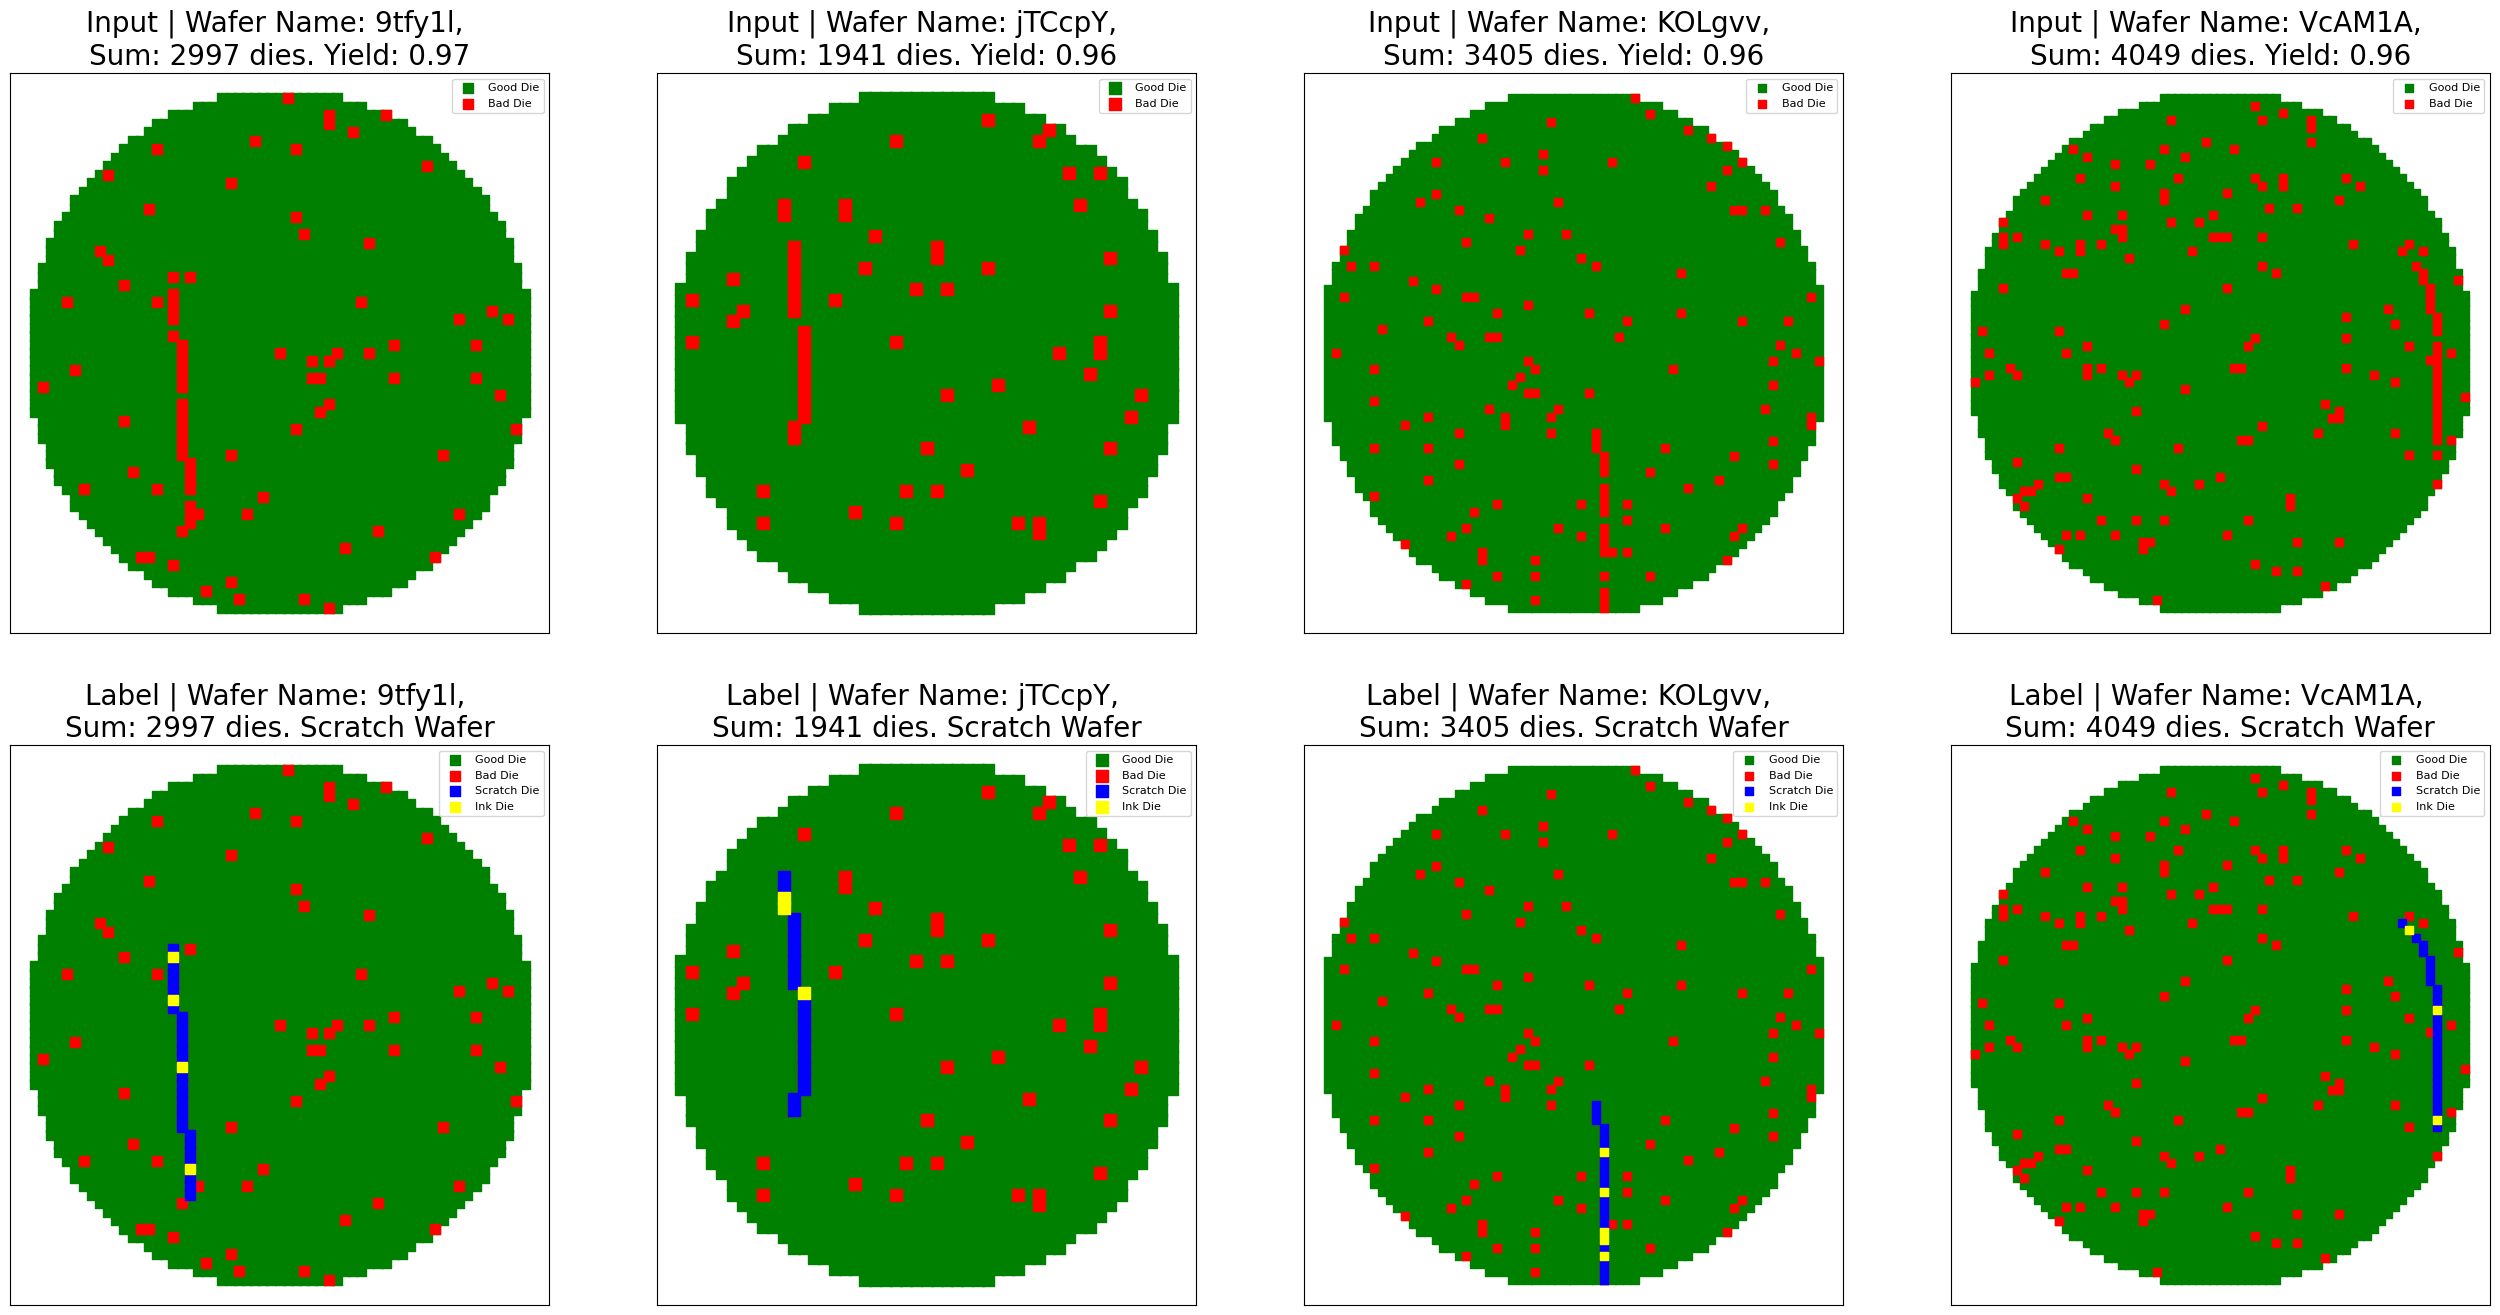

In [6]:
n_samples = 4
list_sample_train = [df_wafers.groupby('WaferName').get_group(group) for group in df_wafers['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_train, figsize = 8, labels = True)

the unlabeld test data

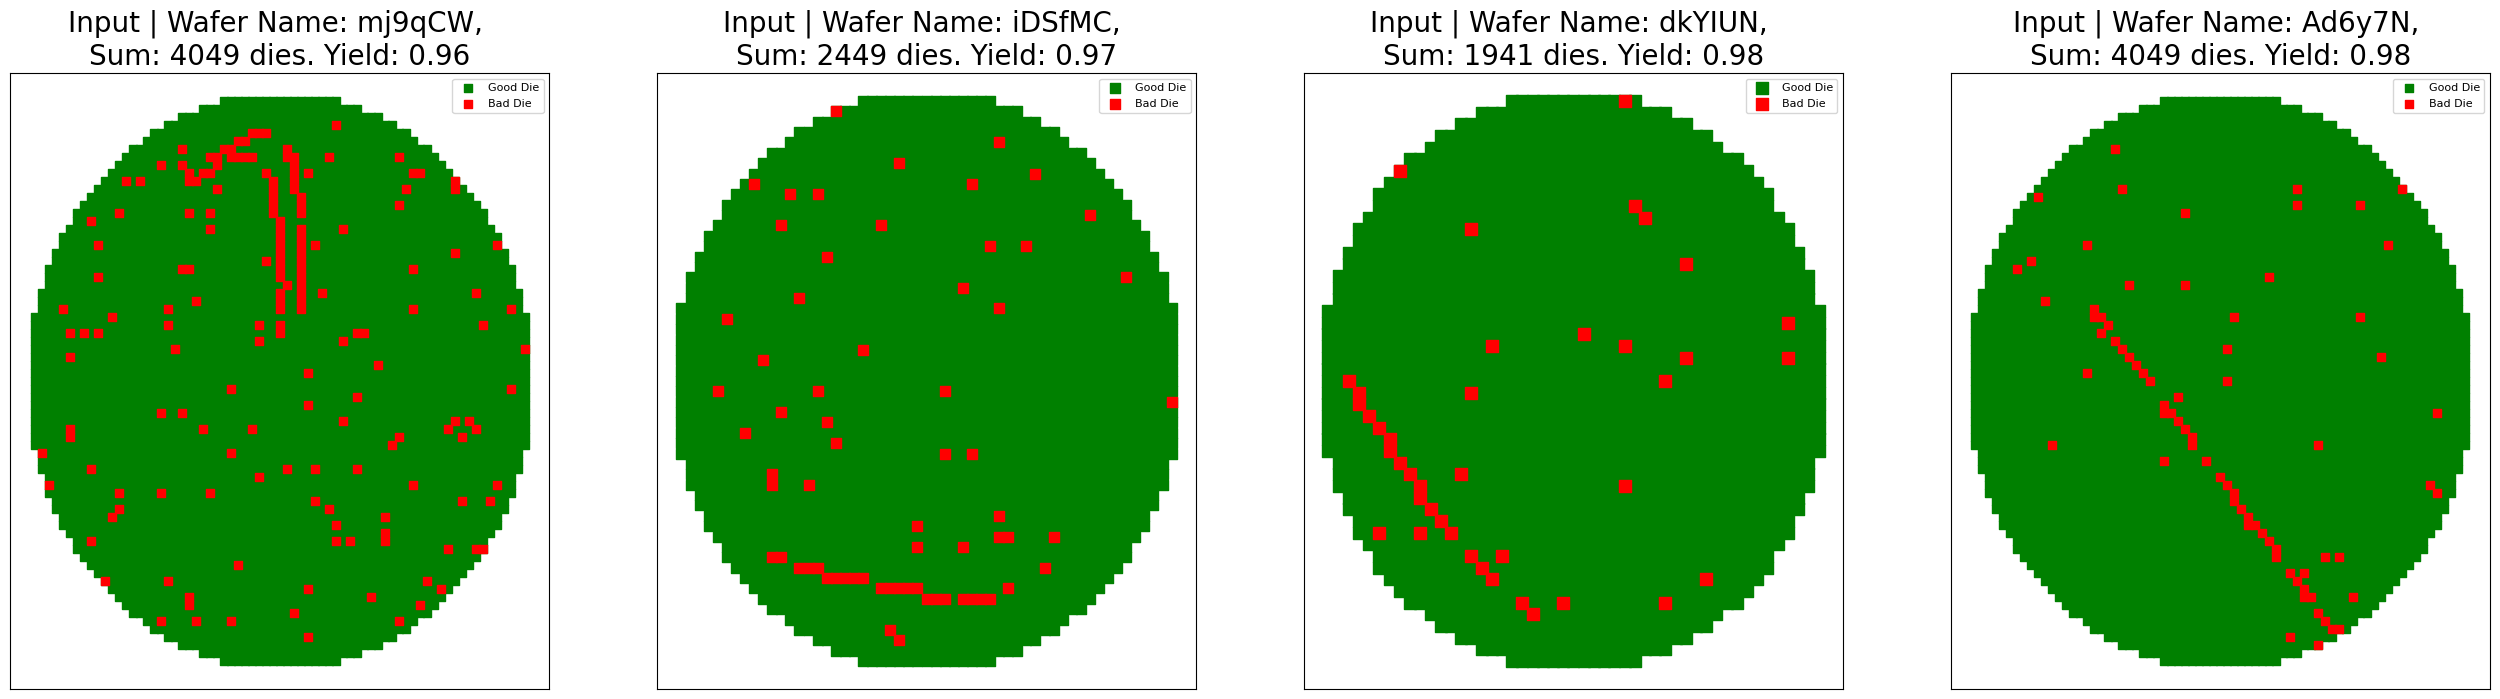

In [7]:
list_sample_test = [df_wafers_test.groupby('WaferName').get_group(group) for group in df_wafers_test['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_test, figsize = 8, labels = False)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random, cv2

In [9]:

def to_tensor(df, canvas_size=(70, 70), offset=1, labels=True, threshold=90):
    H, W = canvas_size

    # get coordinates and good die status
    xy = df[['DieX', 'DieY']].to_numpy(dtype=np.int16)
    good = df['IsGoodDie'].to_numpy(dtype=bool)

    # initialize wafer map
    wafer_np = np.zeros((H, W), np.float32)
    wafer_np[xy[good, 1] - offset, xy[good, 0] - offset] = 1.0
    wafer_np[xy[~good, 1] - offset, xy[~good, 0] - offset] = 0.0

    # edge detection
    sobelx = cv2.Sobel(wafer_np, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(wafer_np, cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobelx**2 + sobely**2)

    # normalize Sobel result to [0, 1]
    sobel = cv2.normalize(sobel, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # apply threshold below 90 to 0
    sobel[sobel < threshold] = 0.0

    # normalize
    sobel = sobel.astype(np.float32) / 255.0

    # Stack wafer map and sobel edge map
    input_tensor = np.stack([wafer_np, sobel], axis=0)  # Shape: [2, H, W]

    # Create label tensor if needed
    if labels:
        scratch = df['IsScratchDie'].to_numpy(dtype=bool)
        lbl = np.zeros((H, W), dtype=np.float32)
        lbl[xy[scratch, 1] - offset, xy[scratch, 0] - offset] = 1.0
        return torch.from_numpy(input_tensor), torch.from_numpy(lbl).unsqueeze(0)
    else:
        return torch.from_numpy(input_tensor), None


In [11]:

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        g1 = F.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=True)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = F.interpolate(x1, size=x2.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # The in_channels in this line and in the AttentionUNet class are modified
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=1):
        super().__init__()
        self.enc1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)

        self.up2 = UpBlock(256 + 128, 128)
        self.att2 = AttentionGate(F_g=256, F_l=128, F_int=64)
        self.up1 = UpBlock(128 + 64, 64)
        self.att1 = AttentionGate(F_g=128, F_l=64, F_int=32)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)

        # Decoder with attention
        a2 = self.att2(g=e3, x=e2)
        d2 = self.up2(e3, a2)

        a1 = self.att1(g=d2, x=e1)
        d1 = self.up1(d2, a1)

        out = self.final(d1)
        return torch.sigmoid(out)

the torch dataset is a retrival class for the dataset
and each call to __getitem__ returns a wafer as a tensor after stacking a channel of inlated edges from sobel function
and after augmenting the training data by rotateing it

In [12]:
class WaferDataset(Dataset):
    def __init__(self, df, wafer_ids, to_tensor=to_tensor, augment=True, labeled=True):
        self.df = df
        self.wafer_ids = wafer_ids
        self.to_tensor = to_tensor
        self.augment = augment
        self.labeled = labeled

    def __len__(self):
        return len(self.wafer_ids)

    def __getitem__(self, idx):
        wafer_df = self.df[self.df['WaferName'] == self.wafer_ids[idx]]
        img, label = self.to_tensor(wafer_df, labels=self.labeled)  # label may be empty tensor if unlabeled

        if self.augment:
            # rotate 0, 90, 180, 270 degrees
            k = random.choice([0, 1, 2, 3])
            # Change the dims argument for rotation
            img = torch.rot90(img, k, dims=[1, 2])

            #Checking if label exists
            if label is not None and label.numel() > 0:
                label = torch.rot90(label, k, dims=[1, 2]) #dims argument to [1, 2] for 2D rotation

        if not self.labeled:
        #If labeled is False, return a zero tensor for label
            label = torch.zeros_like(img[0:1]) #Create a dummy label of same shape as first element in img

        return img, label # Return img and label regardless of augmentation

In [13]:

# unique wafer IDs
all_wafer_ids = df_wafers['WaferName'].unique()

# Split: 70% train, 30% test
train_ids, val_ids = train_test_split(all_wafer_ids, test_size=0.30, random_state=42)

df_train = df_wafers[df_wafers['WaferName'].isin(train_ids)]
df_val   = df_wafers[df_wafers['WaferName'].isin(val_ids)]

train_ds = WaferDataset(df_train, wafer_ids=train_ids, augment=True)
val_ds   = WaferDataset(df_val,   wafer_ids=val_ids, augment=False)

train_loader = DataLoader(train_ds, batch_size=64,
                          num_workers=4, pin_memory=True)

val_loader = DataLoader(val_ds, batch_size=8,
                        shuffle=False, num_workers=4, pin_memory=True)



In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionUNet().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.2, patience=3, min_lr=1e-6)

loss_fn = nn.BCELoss()

def run_epoch(dataloader, model, optimizer=None):
    model.train() if optimizer else model.eval()
    total_loss, total_dice, total_iou = 0, 0, 0
    count = 0

    for img, lbl in dataloader:
        img, lbl = img.to(device), lbl.to(device)
        pred = model(img)
        loss = loss_fn(pred, lbl)


        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # stats
        pred_bin = (pred > 0.5).float()
        intersection = (pred_bin * lbl).sum(dim=(1,2,3))
        union = ((pred_bin + lbl) > 0).float().sum(dim=(1,2,3))
        dice = (2 * intersection / (pred_bin.sum(dim=(1,2,3)) + lbl.sum(dim=(1,2,3)) + 1e-6)).mean()
        iou = (intersection / (union + 1e-6)).mean()

        total_loss += loss.item()
        total_dice += dice.item()
        total_iou += iou.item()
        count += 1

    return total_loss / count, total_dice / count, total_iou / count


Epoch 00  Train L=0.0022 D=0.651 I=0.612 | Val L=0.0023 D=0.661 I=0.620
Epoch 01  Train L=0.0021 D=0.653 I=0.614 | Val L=0.0024 D=0.658 I=0.616
Epoch 02  Train L=0.0021 D=0.655 I=0.616 | Val L=0.0021 D=0.663 I=0.623


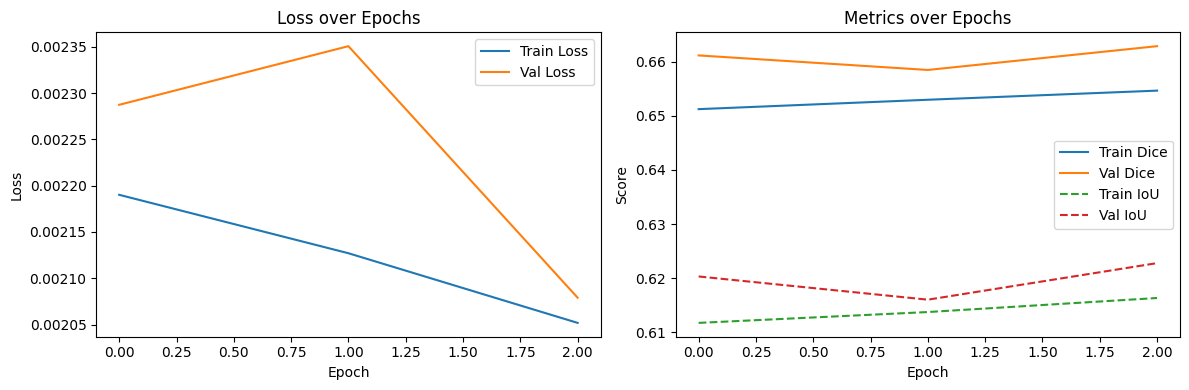

In [31]:


train_losses, val_losses = [], []
train_dices, val_dices = [], []
train_ious, val_ious = [], []

for epoch in range(30):
    train_loss, train_dice, train_iou = run_epoch(train_loader, model, opt)
    val_loss, val_dice, val_iou = run_epoch(val_loader, model, None)
    sched.step(val_dice)

    train_losses.append(train_loss); val_losses.append(val_loss)
    train_dices.append(train_dice); val_dices.append(val_dice)
    train_ious.append(train_iou); val_ious.append(val_iou)

    print(f"Epoch {epoch:02d}  "
          f"Train L={train_loss:.4f} D={train_dice:.3f} I={train_iou:.3f} | "
          f"Val L={val_loss:.4f} D={val_dice:.3f} I={val_iou:.3f}")

# --- resoults over epochs ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Val Dice')
plt.plot(train_ious, label='Train IoU', linestyle='--')
plt.plot(val_ious, label='Val IoU', linestyle='--')
plt.title('Metrics over Epochs'); plt.xlabel('Epoch'); plt.ylabel('Score'); plt.legend()
plt.tight_layout()
plt.show()
# i tained for 30 epochs and evaluted the model on traning mode so i traind 3 more epochs

In [ ]:
#add your thoughts
"""
I'll be honest—it took me many attempts to get this working properly.
To avoid retraining the model extensively,
I needed the code to be efficient and adaptable.
At first, I experimented with different types of CNN architectures,
but the results were poor.
The model often predicted non-existent patterns in the wafers.
I also applied data augmentation by rotating the images,
but saw no noticeable improvement.
Looking for simpler solutions, I turned to traditional image processing techniques.
I used a line detection function, vectorized the results, and fed them into a Random Forest model.
This approach showed better results.
Next, I tweaked the model further, trying Canny edge detection—again,
with no improvement.
I tested Hough transform and other methods to enhance scratch visibility.
I also researched similar problems and studied how others approached them.
Eventually, I tried Sobel edge detection and experimented with the threshold value.
A threshold of 90 gave a clear representation of the scratches.
I then attempted my first models using Sobel-filtered images as input.
I also tried using Vision Transformers (ViTs),
but they required more time to learn the same patterns my earlier CNN attempts had already captured.
Based on this, I concluded that a CNN would be more efficient for my task.
From both my early experiments and the research I conducted, I found that an encoder-decoder CNN
architecture fit my data best. Since I wanted the model to produce outputs
that matched the shape of the input (which varied in size), I kept padding enabled.

I trained the model, and although the IoU scores weren't impressive,
the visual results were actually quite good when I plotted them and i didnt see
a need to tweek the parameters .
"""

# Submission

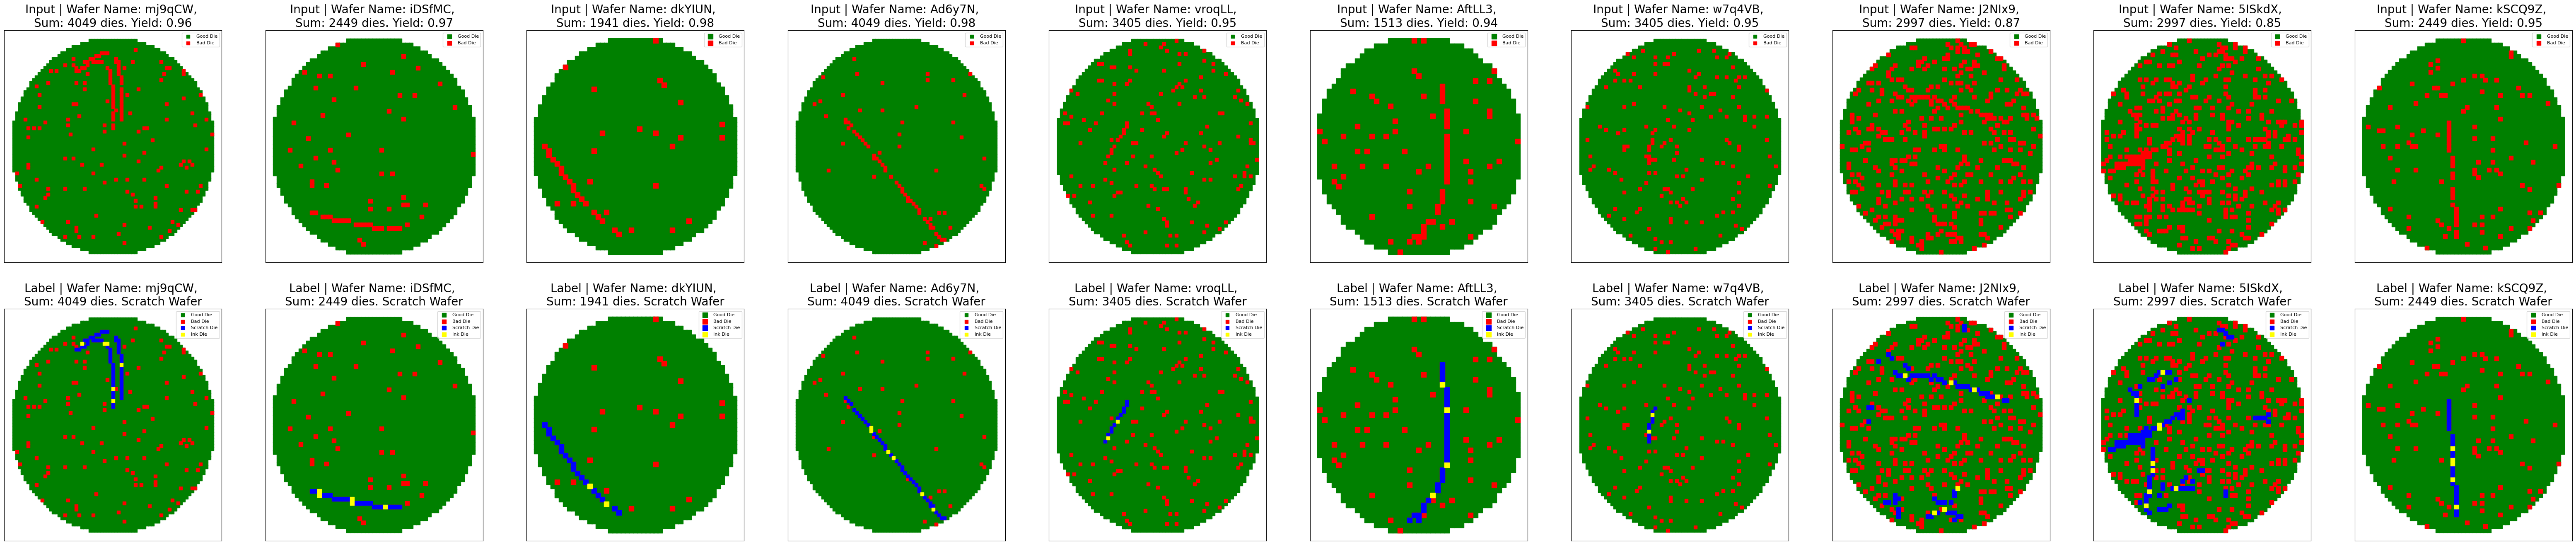

In [ ]:
#TODO
# prediction ds

test_wafer_ids = df_wafers_test['WaferName'].unique()
df_r_test = df_wafers_test[df_wafers_test['WaferName'].isin(test_wafer_ids)]

test_r_ds = WaferDataset(df_r_test, wafer_ids=test_wafer_ids, augment=False, labeled=False)

rt_loader = DataLoader(test_r_ds, batch_size=1,
                        num_workers=1, pin_memory=True)

all_preds = []

with torch.inference_mode():
    for i, (img, _) in enumerate(rt_loader):
        img = img.to(device)
        pred = model(img)

        # Get the wafer dataframe for the current wafer
        wafer_df = df_wafers_test[df_wafers_test['WaferName'] == test_wafer_ids[i]]

        # Extract coordinates of dies in the current wafer
        xy = wafer_df[['DieX', 'DieY']].to_numpy(dtype=np.int16)

        # predictions only for the die locations
        dies_pred = pred[0, 0, xy[:, 1] - 1, xy[:, 0] - 1].cpu().numpy()

        # Threshold the predictions
        dies_pred_binary = (dies_pred > 0.5).astype(int)

        # Extend the predictions list
        all_preds.extend(dies_pred_binary)

# Add the 'IsScratch' column to df_wafers_test
df_wafers_test['IsScratchDie'] = all_preds  #

n_samples = 10
dfs = [df_wafers_test.groupby('WaferName').get_group(group) for group in df_wafers_test['WaferName'].value_counts().index]
selected_dfs = random.sample(dfs, n_samples)
plot_wafer_maps(selected_dfs, figsize=8, labels=True)



above is the wafers and its pridictions 